<a href="http://www.road2quant.com">
    <img src="https://uploads-ssl.webflow.com/5eae007d92687089219c5dec/5eb47da29ced78042e9768ce_long_logo.png" target="_blank" align="right" border="0" width="35%" >
</a>

# Intro to Machine Learning Based Strategies

## Importing the required libraries

The libraries that we are going to use are:
- `Yfinance` to download the daily prices from yahoo finance.
- `Numpy` and `Pandas` to manipulate the data.
- `Matplotlib` to create the charts


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import datetime as dt

### Graph Formating

In [2]:
plt.style.use('seaborn')
plt.rcParams['font.family'] = 'serif'
%matplotlib inline

SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

plt.rc('figure', figsize=(10,6)) 



In [3]:
symbol = ["AMZN"]
rawdata = yf.download(symbol, start="2010-01-01", end="2019-12-31")
rawdata = pd.DataFrame(rawdata['Close'])
rawdata.columns = ['price']

[*********************100%***********************]  1 of 1 completed


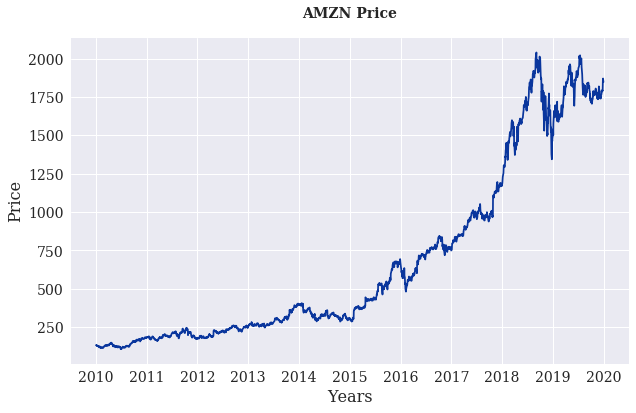

In [4]:
plt.figure()
plt.title('AMZN Price',fontweight="bold", pad=20)
plt.xlabel('Years')
plt.ylabel('Price')
plt.plot(rawdata, color='#0A369D');
# plt.savefig('price.png', facecolor='None')

In [5]:
LR = rawdata.copy()
LR['indx'] = np.arange(len(LR))

split = int(len(LR) * 0.8)
LR_train, LR_test = LR[:split], LR[split:]

X_test  = LR_test['indx'].values
X_train = LR_train['indx'].values
y_train = LR_train['price'].values

reg = np.polyfit(X_train, y_train, deg=1)
reg

array([  0.43376732, -20.04042024])

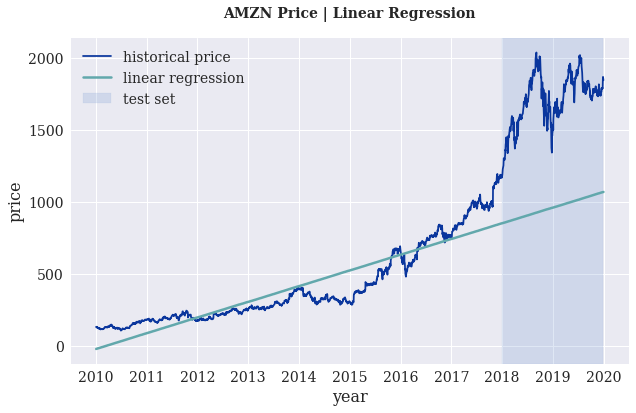

In [6]:
fig = plt.figure()
ax = plt.axes()
ax.plot(LR.index,LR['price'],label='historical price', color='#0A369D')
ax.plot(LR.index, np.polyval(reg, LR['indx']), lw=2.5,
         label='linear regression', color='#62a8ac')
ax.axvspan(LR.index[split], LR.index[len(LR)-1], alpha=0.25, color='#80A1D4', label='test set')
ax.set_title('AMZN Price | Linear Regression',fontweight="bold", pad=20)
ax.set_xlabel('year')
ax.set_ylabel('price')
plt.legend(loc=0);
# plt.savefig('price_regression.png', facecolor='None')

In [7]:
lags = 5
cols = []
lagsR = rawdata.copy()

for lag in range(1, lags + 1):
    col = f'lag_{lag}'
    lagsR[col] = lagsR['price'].shift(lag)
    cols.append(col)
lagsR.dropna(inplace=True)

In [8]:
lagsR.head()

,price,lag_1,lag_2,lag_3,lag_4,lag_5
Date,,,,,,
2010-01-11,130.309998,133.520004,130.000000,132.250000,134.690002,133.899994
2010-01-12,127.349998,130.309998,133.520004,130.000000,132.250000,134.690002
2010-01-13,129.110001,127.349998,130.309998,133.520004,130.000000,132.250000
2010-01-14,127.349998,129.110001,127.349998,130.309998,133.520004,130.000000
2010-01-15,127.139999,127.349998,129.110001,127.349998,130.309998,133.520004


In [9]:
a = lagsR[cols].corr()
a.round(3)

,lag_1,lag_2,lag_3,lag_4,lag_5
lag_1,1.000,1.000,0.999,0.999,0.999
lag_2,1.000,1.000,1.000,0.999,0.999
lag_3,0.999,1.000,1.000,1.000,0.999
lag_4,0.999,0.999,1.000,1.000,1.000
lag_5,0.999,0.999,0.999,1.000,1.000


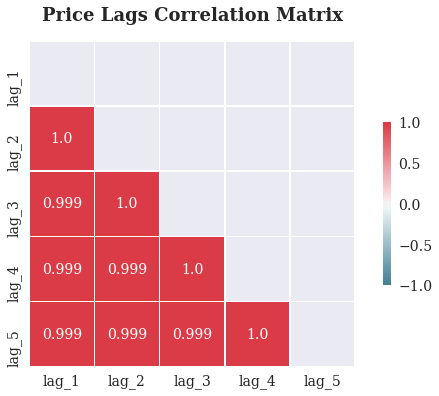

In [10]:
mask = np.triu(np.ones_like(a, dtype=np.bool))
f, ax = plt.subplots(figsize=(10, 6))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(a, mask=mask,  cmap=cmap,  annot=True,fmt=".3", vmin=-1, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.title('Price Lags Correlation Matrix',fontsize=18,fontweight="bold", pad=20);
# plt.savefig('price_corr.png', facecolor='None')

In [11]:
reg = np.linalg.lstsq(lagsR[cols], lagsR['price'],
                      rcond=None)[0]

In [12]:
lagsR['prediction'] = np.dot(lagsR[cols], reg)

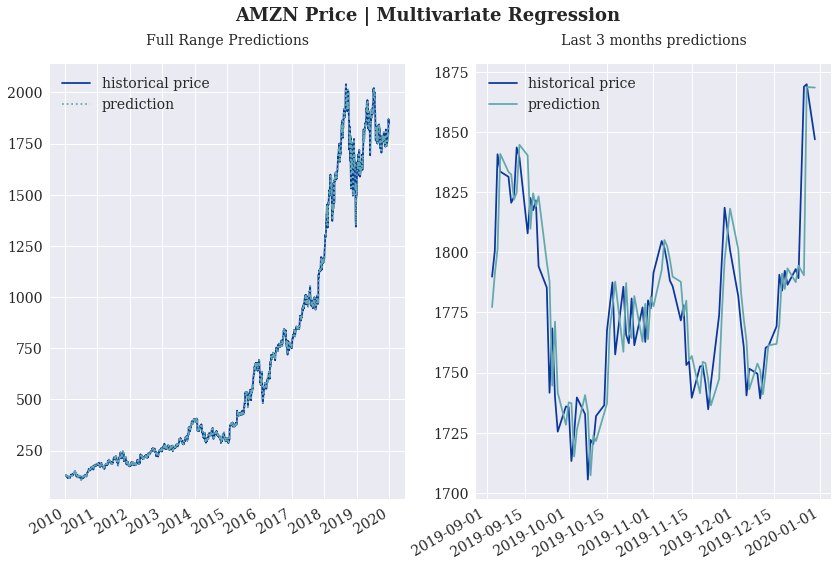

In [13]:
plt.figure(figsize=(14, 8))

plt.subplot(1,2,1)
plt.plot(lagsR.index, lagsR['price'], label='historical price', color='#0A369D')
plt.plot(lagsR.index, lagsR['prediction'], label='prediction', linestyle=':', color='#62a8ac')
plt.title('Full Range Predictions', pad=20)
plt.legend(loc=0)
plt.setp(plt.xticks()[1], rotation=30, ha='right');

plt.subplot(1,2,2)
plt.plot(lagsR.loc['2019-9-1':].index, lagsR['price'].loc['2019-9-1':],
         label='historical price', color='#0A369D')
plt.plot(lagsR.loc['2019-9-1':].index, lagsR['prediction'].loc['2019-9-1':],
         label='prediction', linestyle='-', color='#62a8ac')
plt.title('Last 3 months predictions', pad=20)
plt.legend(loc=0)
plt.setp(plt.xticks()[1], rotation=30, ha='right')
plt.suptitle("AMZN Price | Multivariate Regression",fontweight="bold");
# plt.savefig('price_multi.png', facecolor='None')

In [14]:
rets = rawdata.copy()
rets['returns'] = np.log(rets/rets.shift(1))

lags = 5
cols = []

for lag in range(1, lags + 1):
    col = f'lag_{lag}'
    rets[col] = rets['returns'].shift(lag)
    cols.append(col)
rets.dropna(inplace=True)

rets.head()

,price,returns,lag_1,lag_2,lag_3,lag_4,lag_5
Date,,,,,,,
2010-01-12,127.349998,-0.022977,-0.024335,0.026717,-0.017160,-0.018282,0.005883
2010-01-13,129.110001,0.013726,-0.022977,-0.024335,0.026717,-0.017160,-0.018282
2010-01-14,127.349998,-0.013726,0.013726,-0.022977,-0.024335,0.026717,-0.017160
2010-01-15,127.139999,-0.001650,-0.013726,0.013726,-0.022977,-0.024335,0.026717
2010-01-19,127.610001,0.003690,-0.001650,-0.013726,0.013726,-0.022977,-0.024335


In [15]:
b = rets[cols].corr()
b.round(3)

,lag_1,lag_2,lag_3,lag_4,lag_5
lag_1,1.000,-0.010,-0.026,-0.015,-0.031
lag_2,-0.010,1.000,-0.011,-0.026,-0.015
lag_3,-0.026,-0.011,1.000,-0.010,-0.026
lag_4,-0.015,-0.026,-0.010,1.000,-0.010
lag_5,-0.031,-0.015,-0.026,-0.010,1.000


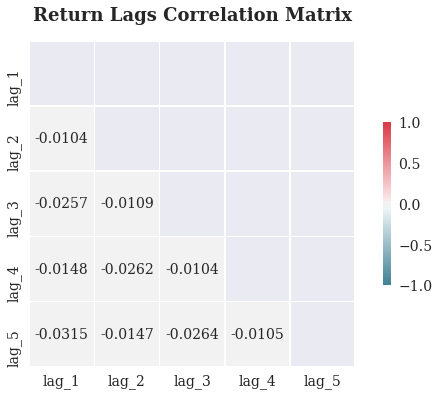

In [16]:
mask = np.triu(np.ones_like(b, dtype=np.bool))
f, ax = plt.subplots(figsize=(10, 6))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(b, mask=mask, cmap=cmap ,  annot=True ,fmt=".3",vmin=-1, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.title('Return Lags Correlation Matrix',fontsize=18,fontweight="bold", pad=20);
# plt.savefig('returns_corr.png', facecolor='None')

In [17]:
reg = np.linalg.lstsq(rets[cols], rets['returns'],
                      rcond=None)[0]
reg

array([-0.00713614, -0.02437168, -0.01259411, -0.02903491,  0.01514668])

In [18]:
rets['prediction'] = np.dot(rets[cols], reg)

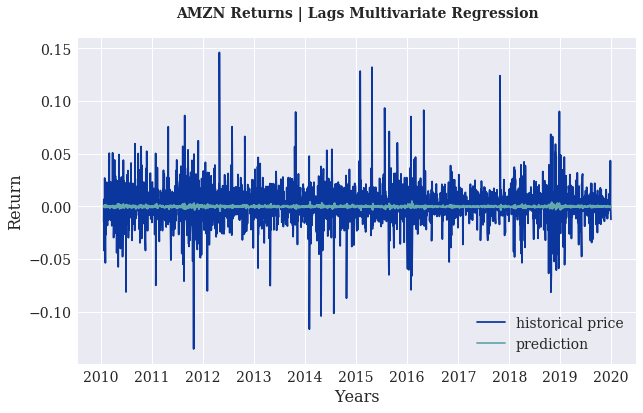

In [19]:
plt.figure()
plt.title('AMZN Returns | Lags Multivariate Regression',fontweight="bold", pad=20)
plt.xlabel('Years')
plt.ylabel('Return')
plt.plot(rets['returns'].iloc[lags:], label='historical price', color='#0A369D')
plt.plot(rets['prediction'].iloc[lags:], label='prediction', color='#62a8ac')
plt.legend(loc=0);
# plt.savefig('returns_multi.png', facecolor='None')

In [20]:
rets['prediction'] = np.sign(rets['prediction'])

In [21]:
hits = np.sign(rets['returns'] *
               rets['prediction']).value_counts()
hits

 1.0    1274
-1.0    1229
 0.0       6
dtype: int64

In [22]:
hits.values[0] / sum(hits)

0.5077720207253886

In [23]:
from sklearn.metrics import accuracy_score
from sklearn import linear_model

lm = linear_model.LogisticRegression(C=1e6, solver='lbfgs',
                                     multi_class='auto')
lm.fit(rets[cols], np.sign(rets['returns']))

LogisticRegression(C=1000000.0, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [24]:
rets['prediction'] = lm.predict(rets[cols])

In [25]:
rets['prediction'].value_counts()

 1.0    2418
-1.0      91
Name: prediction, dtype: int64

In [26]:
hits = np.sign(rets['returns'].iloc[lags:] *
               rets['prediction'].iloc[lags:]
              ).value_counts()
hits

 1.0    1331
-1.0    1167
 0.0       6
dtype: int64

In [27]:
accuracy_score(rets['prediction'],
               np.sign(rets['returns']))

0.5312873654842567

In [28]:
rets['strategy'] = rets['prediction'] * rets['returns']

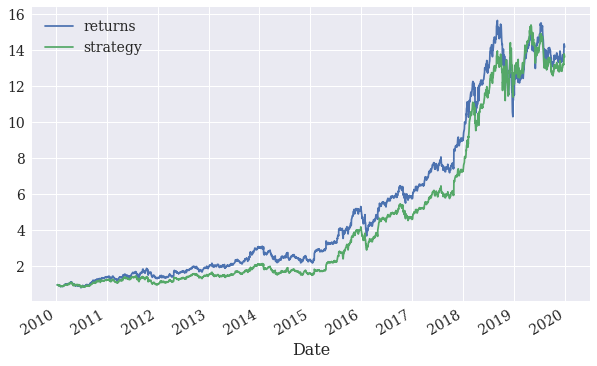

In [29]:
rets[['returns', 'strategy']].cumsum().apply(np.exp).plot(
                                        figsize=(10, 6));

In [33]:
np.random.seed(500)
import tensorflow as tf
# tf.logging.set_verbosity(tf.logging.ERROR)
# tf.random.set_random_seed(500)
from keras.models import Sequential
from keras.layers import Dense

Using TensorFlow backend.


In [34]:
model = Sequential()
model.add(Dense(64, activation='relu',
                input_shape=(lags,)))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [35]:
rets['direction'] = np.where(rets['returns'] > 0, 1, 0)
model.fit(rets[cols],
          rets['direction'],
          epochs=100, verbose=False)

In [37]:
pred = model.predict_classes(rets[cols])

In [38]:
rets['prediction'] = np.where(pred > 0, 1, -1)

In [39]:
hits = np.sign(rets['returns'].iloc[lags:] *
               rets['prediction'].iloc[lags:]
              ).value_counts()
hits

 1.0    1428
-1.0    1070
 0.0       6
dtype: int64

In [40]:
accuracy_score(rets['prediction'],
               np.sign(rets['returns']))

0.5695496213630928

## References

Inspired by the book *Artificial Intelligence for Finance* by Yves Hilpisch.

<img src="https://images-na.ssl-images-amazon.com/images/I/51VEL0RZbzL._SX379_BO1,204,203,200_.jpg" width="250" style="float:left">

and the program *Certificate in Python for Algorithmic Trading*

<img src="https://home.tpq.io/wp-content/uploads/2019/11/algo_broch_cov_shadow.png" width="250" style="float:left">

<a href="http://www.road2quant.com">
    <img src="https://uploads-ssl.webflow.com/5eae007d92687089219c5dec/5eb47da29ced78042e9768ce_long_logo.png" target="_blank" align="right" border="0" width="35%" >
</a>